# Capstone: Bitcoin: Time Series Forecasting Using Machine Learning

## 3.1 Modeling - Time Series: SARIMA and SARIMAX
---

## Imports
---

In [1]:
import pandas as pd
import numpy as np

import itertools

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

from sklearn.metrics import mean_squared_error, mean_absolute_error

from tqdm import tqdm_notebook as tqdm
import _pickle as pickle
plt.style.use('ggplot')

## Loading in and formatting the Data

In [2]:
bc = pd.read_csv('data/ohlc_price.csv')
bc.tail()

,t,Close,High,Low,Open
3772,2020-11-13,16311.513323,16462.716548,15992.152801,16292.717048
3773,2020-11-14,16075.452734,16314.263353,15776.768439,16314.263353
3774,2020-11-15,15962.098952,16119.264673,15793.533917,16063.671431
3775,2020-11-16,16709.612284,16804.409142,15887.108131,15953.998053
3776,2020-11-17,17667.381593,17782.620109,16564.544992,16700.900927


In [3]:
bc.rename(columns={'t':'Date'}, inplace=True)

In [4]:
bc

,Date,Close,High,Low,Open
0,2010-07-17,0.049510,0.049510,0.049510,0.049510
1,2010-07-18,0.085840,0.085850,0.059410,0.059410
2,2010-07-19,0.080800,0.093070,0.078550,0.090900
3,2010-07-20,0.074733,0.081810,0.074260,0.081810
4,2010-07-21,0.079210,0.079210,0.066340,0.074250
...,...,...,...,...,...
3772,2020-11-13,16311.513323,16462.716548,15992.152801,16292.717048
3773,2020-11-14,16075.452734,16314.263353,15776.768439,16314.263353
3774,2020-11-15,15962.098952,16119.264673,15793.533917,16063.671431
3775,2020-11-16,16709.612284,16804.409142,15887.108131,15953.998053


### Converting Dates into a Datetime Format

In [5]:
bc['Date'] = pd.to_datetime(bc.Date)
bc.dtypes

Date     datetime64[ns]
Close           float64
High            float64
Low             float64
Open            float64
dtype: object

#### Setting dates as the index

In [6]:
bc.set_index('Date', inplace=True)
bc.head()

,Close,High,Low,Open
Date,,,,
2010-07-17,0.049510,0.04951,0.04951,0.04951
2010-07-18,0.085840,0.08585,0.05941,0.05941
2010-07-19,0.080800,0.09307,0.07855,0.09090
2010-07-20,0.074733,0.08181,0.07426,0.08181
2010-07-21,0.079210,0.07921,0.06634,0.07425


### Exporting this data for later use

In [7]:
with open("curr_bitcoin.pickle", 'wb') as fp:
    pickle.dump(bc, fp)

## Plotting Bitcoin's Historical Prices

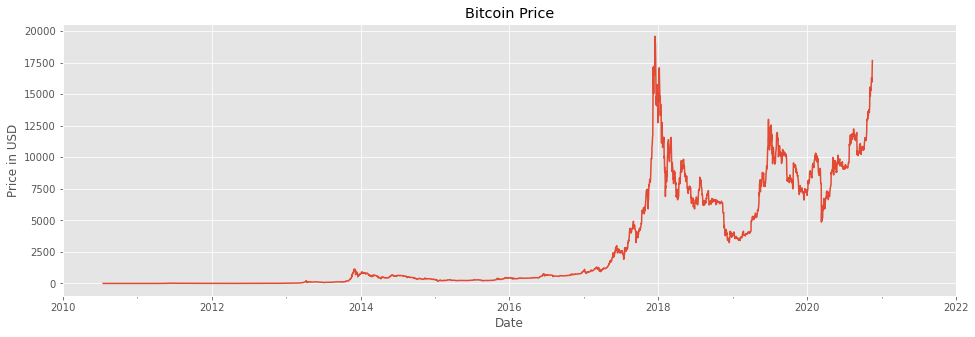

In [8]:
bc['Close'].plot(figsize=(16,5), xlim=('2010', '2022'))
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Bitcoin Price')
plt.savefig('btcprice.png')
plt.show()

## Detrending, Decomposition and Statistical Tests

<Figure size 1080x864 with 0 Axes>

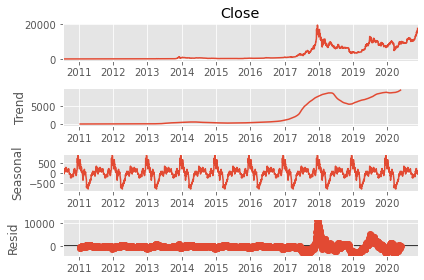

In [9]:
plt.figure(figsize=(15,12))
seasonal_decompose(bc['Close'], period=364).plot();

### ACF and PACF for the Price

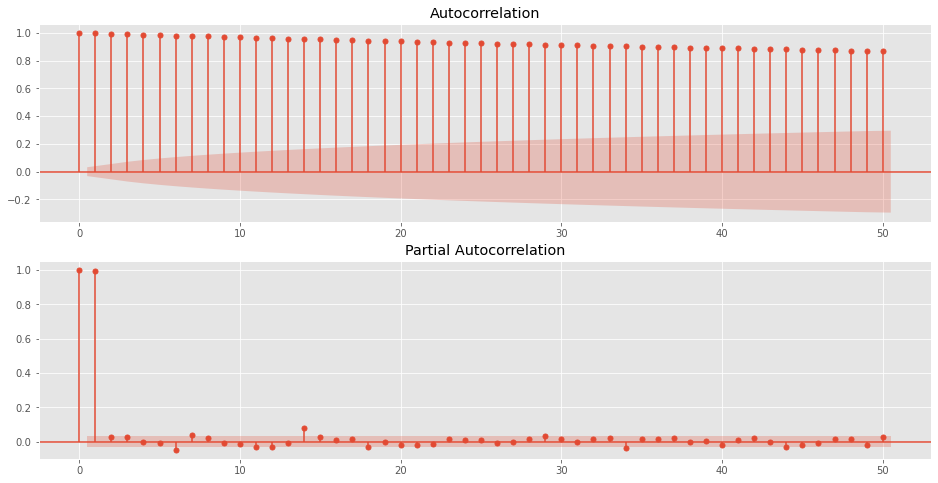

In [10]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))
plot_acf(bc['Close'], ax=ax1, lags=50)
plot_pacf(bc['Close'], ax=ax2, lags=50)
plt.show()

### Testing for Stationarity

In [11]:
#ADF

In [12]:
# ADF function (https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    if dfoutput['p-value'] > 0.05:
        print('Series is not Stationary')
    else:
        print('Series is Stationary')

In [13]:
adf_test(bc['Close'])

Results of Dickey-Fuller Test:
Test Statistic                   -0.103660
p-value                           0.949073
#Lags Used                       27.000000
Number of Observations Used    3749.000000
Critical Value (1%)              -3.432095
Critical Value (5%)              -2.862311
Critical Value (10%)             -2.567181
dtype: float64
Series is not Stationary


For the ADF, the null hypothesis is the presence of a unit root, or that the series is non-stationary. Since the p-value is > 0.05, the null hypothesis cannot be rejected. Thus, the series is non-stationary.

In [14]:
# KPSS
def kpss_test(timeseries):
    stats, p, lags, critical_values = kpss(timeseries, 'ct')
    print(f'Test Statistics : {stats}')
    print(f'p-value : {p}')
    print(f'Critical Values : {critical_values}')

    if p < 0.05:
        print('Series is not Stationary')
    else:
        print('Series is Stationary')

In [15]:
kpss_test(bc['Close'])

Test Statistics : 1.459539238271983
p-value : 0.01
Critical Values : {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is not Stationary


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


For the KPSS, the null hypothesis is that the series is stationary. Since the p-value is < 0.05, the null hypothesis is rejected. Thus, the series is non-stationary.

Both tests indicate the data is non-stationary. The data series needs to be detrended.

### Method #1 - Differencing the Data

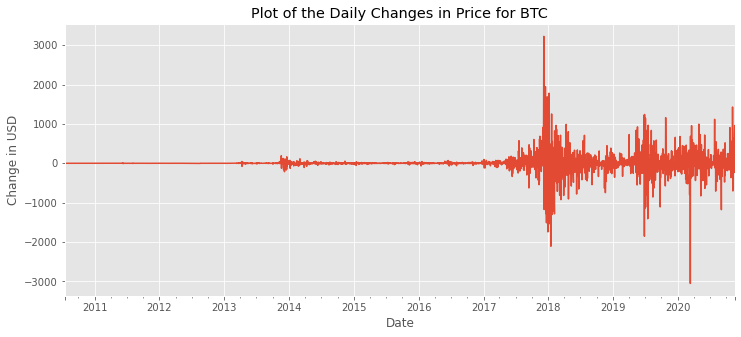

In [16]:
# Differencing the price
bc_diff = bc['Close'].diff(1).dropna()

# Plotting the differences daily
bc_diff.plot(figsize=(12,5))
plt.title('Plot of the Daily Changes in Price for BTC')
plt.ylabel('Change in USD')
plt.show()

#### Testing for Stationarity

In [17]:
adf_test(bc_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.103180e+01
p-value                        5.643742e-20
#Lags Used                     2.600000e+01
Number of Observations Used    3.749000e+03
Critical Value (1%)           -3.432095e+00
Critical Value (5%)           -2.862311e+00
Critical Value (10%)          -2.567181e+00
dtype: float64
Series is Stationary


In [18]:
# KPSS
stats, p, lags, critical_values = kpss(bc_diff, 'ct')

print(f'Test Statistics : {stats}')
print(f'p-value : {p}')
print(f'Critical Values : {critical_values}')

if p < 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')

Test Statistics : 0.04074782534681394
p-value : 0.1
Critical Values : {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is Stationary


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


#### ACF and PACF for the Differencing

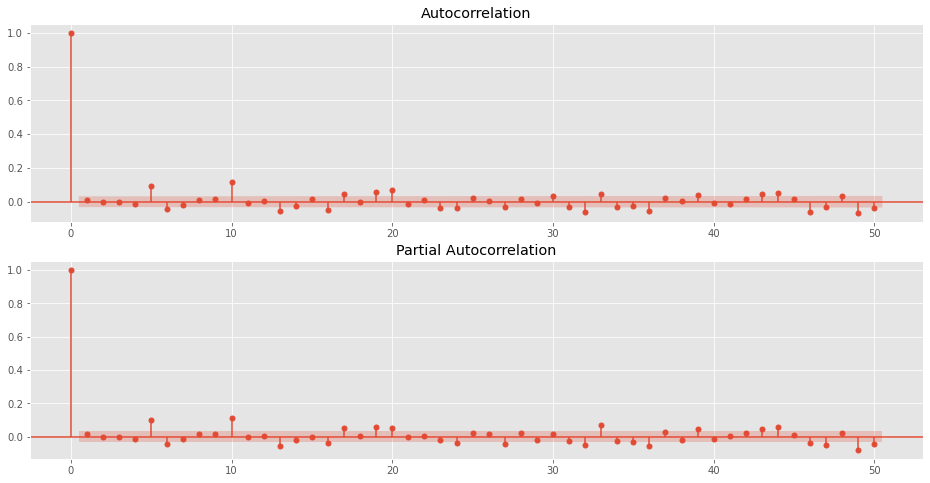

In [19]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))
plot_acf(bc_diff, ax=ax1, lags=50)
plot_pacf(bc_diff, ax=ax2, lags=50)
plt.show()

Appears to be some correlation at day 5 and 10 mostly.

Differencing makes the data series stationary.

### Method #2 - Taking the Log then differencing

In [20]:
# Converting the data to a logarithmic scale
bc_log = pd.DataFrame(np.log(bc['Close']))

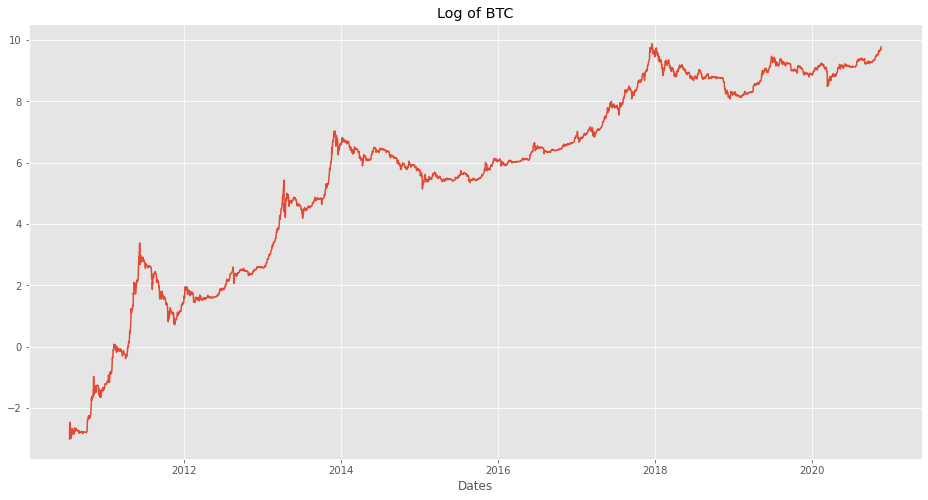

In [21]:
# Plotting the log of the data
plt.figure(figsize=(16,8))
plt.plot(bc_log)

plt.title('Log of BTC')
plt.xlabel('Dates')

plt.savefig('btc_log.png')
plt.show()

#### Testing for Stationarity

In [22]:
adf_test(bc_log)

Results of Dickey-Fuller Test:
Test Statistic                   -2.568111
p-value                           0.099769
#Lags Used                       23.000000
Number of Observations Used    3753.000000
Critical Value (1%)              -3.432094
Critical Value (5%)              -2.862310
Critical Value (10%)             -2.567180
dtype: float64
Series is not Stationary


In [23]:
# KPSS
stats, p, lags, critical_values = kpss(bc_log, 'ct')

print(f'Test Statistics : {stats}')
print(f'p-value : {p}')
print(f'Critical Values : {critical_values}')

if p < 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')

Test Statistics : 1.443777556180776
p-value : 0.01
Critical Values : {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is not Stationary


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


The log(price) does not make the data series stationary.

In [24]:
# Differencing the log values
log_diff = bc_log.diff().dropna()

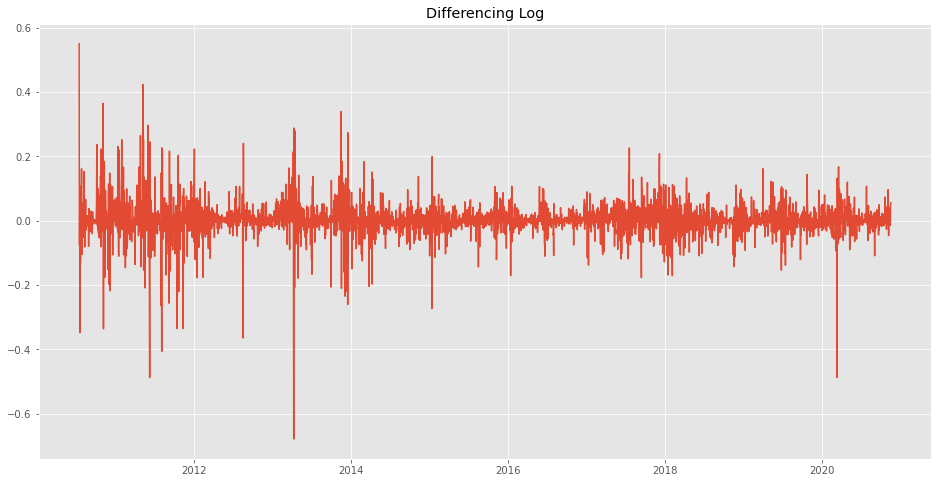

In [25]:
# Plotting the daily log difference
plt.figure(figsize=(16,8))
plt.plot(log_diff)
plt.title('Differencing Log')
plt.savefig('logdiff.png')
plt.show()

#### Testing for Stationarity

In [26]:
adf_test(log_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.019875e+01
p-value                        6.048199e-18
#Lags Used                     2.200000e+01
Number of Observations Used    3.753000e+03
Critical Value (1%)           -3.432094e+00
Critical Value (5%)           -2.862310e+00
Critical Value (10%)          -2.567180e+00
dtype: float64
Series is Stationary


In [27]:
# KPSS
stats, p, lags, critical_values = kpss(log_diff, 'ct')

print(f'Test Statistics : {stats}')
print(f'p-value : {p}')
print(f'Critical Values : {critical_values}')

if p < 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')

Test Statistics : 0.08351775136239044
p-value : 0.1
Critical Values : {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is Stationary


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


The results of both tests indicate the log-differenced data series is stationary.

#### ACF and PACF for the Log Difference

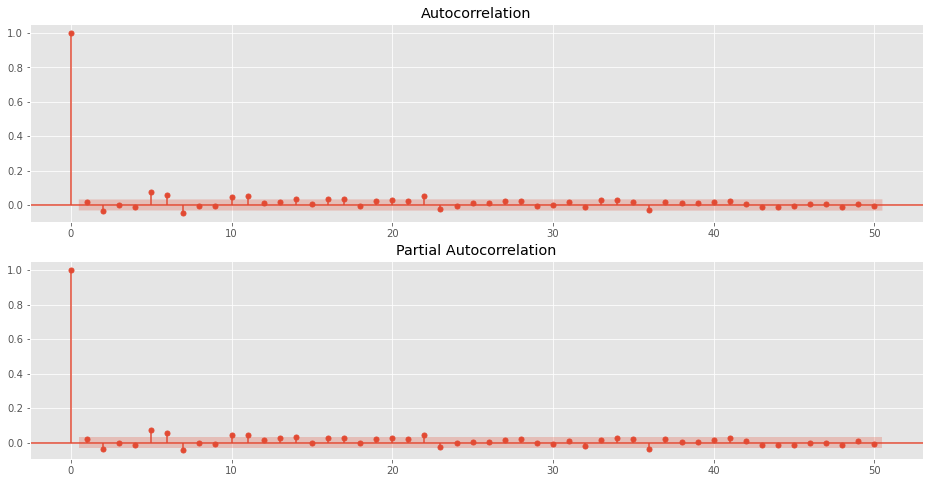

In [28]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))
plot_acf(log_diff, ax=ax1, lags=50)
plot_pacf(log_diff, ax=ax2, lags=50)
plt.savefig('acfpacf.png')
plt.show()

## Modeling

### Hold-out based Validation

In [29]:
# Splitting 80/20
index = round(len(bc)*.80)

train = bc_log.iloc[:index]
test = bc_log.iloc[index:]

## SARIMA

#### Finding the Best Parameters for ARIMA

In [30]:
def best_param(model, data, pdq, pdqs):
    """
    Loops through each possible combo for pdq and pdqs
    Runs the model for each combo
    Retrieves the model with lowest AIC score
    """
    ans = []
    for comb in tqdm(pdq):
        for combs in tqdm(pdqs):
            try:
                mod = model(data,
                            order=comb,
                            seasonal_order=combs,
                            enforce_stationarity=False,
                            enforce_invertibility=False,
                            freq='D',
                            suppress_warnings=True)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    return ans_df.loc[ans_df['aic'].idxmin()]

In [31]:
# Assigning variables for p, d, q.
p = d = q = range(0,6)
d = range(2)

# Creating a list of all possible combinations of p, d, and q.
pdq = list(itertools.product(p, d, q))

# Keeping seasonality at zeroes
pdqs = [(0,0,0,0)]

In [32]:
# Finding the best parameters
best_param(SARIMAX, bc_log, pdq, pdqs)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq        (5, 1, 5)
pdqs    (0, 0, 0, 0)
aic         -11360.9
Name: 71, dtype: object

#### Best Parameters according to the function

In [33]:
# pdq        (5, 1, 5)
# pdqs    (0, 0, 0, 0)
# aic         -11342.4

### Fitting and Training SARIMAX

In [34]:
# Fitting the model to the training set
model = SARIMAX(train, 
                order=(5, 1, 5), 
                seasonal_order=(0,0,0,0), 
                freq='D', 
                enforce_stationarity=False, 
                enforce_invertibility=False)
output = model.fit()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### Summary and Diagnostics from fitting the model

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3022
Model:               SARIMAX(5, 1, 5)   Log Likelihood                4389.798
Date:                Wed, 18 Nov 2020   AIC                          -8757.595
Time:                        17:15:17   BIC                          -8691.470
Sample:                    07-17-2010   HQIC                         -8733.816
                         - 10-24-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4000      0.066      6.094      0.000       0.271       0.529
ar.L2         -0.1292      0.042     -3.069      0.002      -0.212      -0.047
ar.L3          0.2555      0.066      3.851      0.0

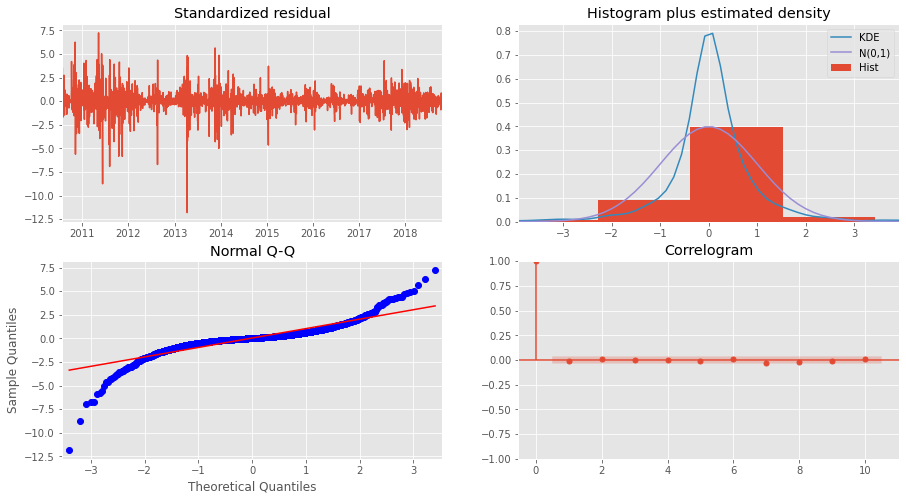

In [35]:
print(output.summary())
output.plot_diagnostics(figsize=(15,8))
plt.show()

### Predictions with ARIMA

### Transforming the Data back to its original price

In [36]:
# Values to test against the test set
fc   = output.get_forecast(len(test))
conf = fc.conf_int()

# Transforming the values back to normal
fc_series    = np.exp(pd.Series(fc.predicted_mean, index=test.index))
lower_series = np.exp(pd.Series(conf.iloc[:, 0], index=test.index))
upper_series = np.exp(pd.Series(conf.iloc[:, 1], index=test.index))

etrain = np.exp(train)
etest  = np.exp(test)

# Values to test against the train set, see how the model fits
predictions = output.get_prediction(start=pd.to_datetime('2018'), dynamic=False)
pred        = np.exp(predictions.predicted_mean)

# Confidence interval for the training set
conf_int   = np.exp(predictions.conf_int())
low_conf   = np.exp(pd.Series(conf_int.iloc[:,0], index=train.index))
upper_conf = np.exp(pd.Series(conf_int.iloc[:,1], index=train.index))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2095: RuntimeWarning: invalid value encountered in multiply
  endog = np.empty((nforecast, self.k_endog)) * np.nan
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Plotting the Fitted Model and Testing against the Test set

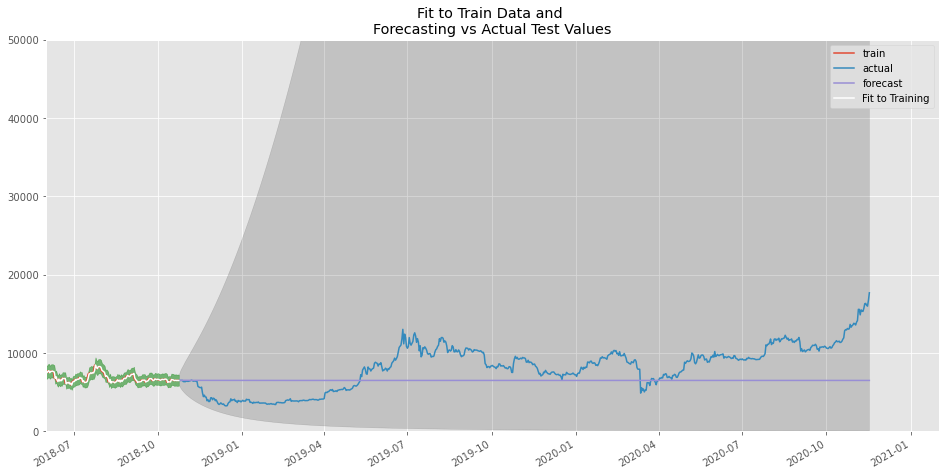

In [37]:
rcParams['figure.figsize'] = 16, 8

# Plotting the training set, test set,forecast, and confidence interval.
plt.plot(etrain, label='train')
plt.plot(etest, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

# Plotting against the training data
pred.plot(label='Fit to Training', color='w')

# Confidence interval for the fitted data
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='g',alpha=.5)

# Limiting the viewing size
plt.xlim(['2018-06', '2021-02'])
plt.ylim([0, 50000])

plt.title('Fit to Train Data and \nForecasting vs Actual Test Values')
plt.legend()
plt.savefig('btc_fit_fc.png')
plt.show()

### Calculating the RMSE for SARIMA

In [38]:
forecast = pred
actual_val = etrain.Close

# Calculating our errors
rmse = np.sqrt(((forecast - actual_val) ** 2).mean())

print("The Root Mean Squared Error: ", rmse)
# print("The Mean Absolute Error: ", mean_absolute_error(actual_val, forecast))

The Root Mean Squared Error:  416.9343620763006


### Forecasting Future Values

#### Fitting the model to the entire dataset

In [39]:
model = SARIMAX(bc_log, 
                order=(5, 1, 5), 
                seasonal_order=(0,0,0,0), 
                freq='D', 
                enforce_stationarity=False, 
                enforce_invertibility=False)
output = model.fit()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [40]:
# Getting the forecast of future values
future = output.get_forecast(steps=30)

# Transforming values back
pred_fut = np.exp(future.predicted_mean)

# Confidence interval for our forecasted values
pred_conf = future.conf_int()

# Transforming value back
pred_conf = np.exp(pred_conf)

### Plotting the forecasted values

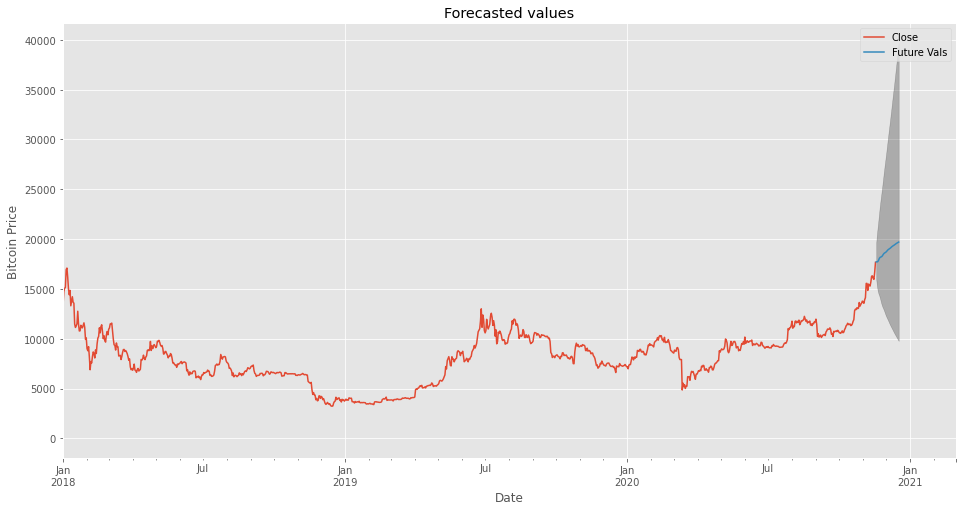

In [41]:
# Plotting the prices up to the most recent
ax = np.exp(bc_log).plot(label='Actual', figsize=(16,8))

# Plottting the forecast
pred_fut.plot(ax=ax, label='Future Vals')

# Shading in the confidence interval
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin Price')
ax.set_xlim(['2018-01', '2021-03'])

plt.title('Forecasted values')
plt.legend()
plt.savefig('fc_val.png')
plt.show()

### Zooming in on the Graph above

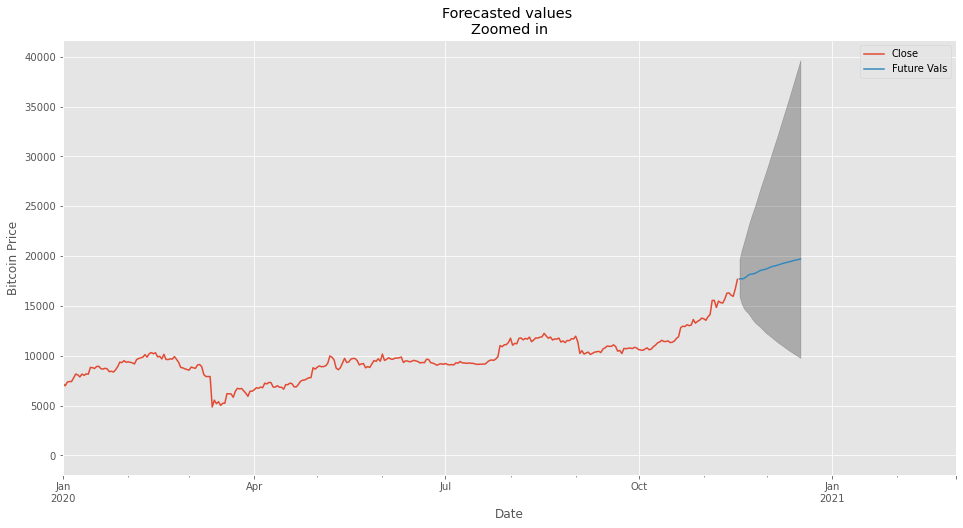

In [42]:
ax = np.exp(bc_log).plot(label='Actual', figsize=(16,8))
pred_fut.plot(ax=ax, label='Future Vals')

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin Price')
ax.set_xlim(['2020-01','2021-03'])

plt.title('Forecasted values \nZoomed in')
plt.legend()
plt.savefig('fc_zoom.png')
plt.show()

## Incorporating Exogenous Variables: SARIMAX

#### Feature Extraction: Rolling Windows

Using the pmdarima library this time for Auto Arima.

In [43]:
import pmdarima as pmd

In [44]:
with open("combined_.pickle",'rb') as fp:
    df = pickle.load(fp)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94606 entries, 2010-01-01 00:00:00 to 2020-11-18 21:50:00
Columns: 111 entries, market_mvrv_more_155 to indicators_sopr_less_155
dtypes: float64(111)
memory usage: 80.8 MB


In [46]:
df.head()

,market_mvrv_more_155,ma128,ma14,ma200,ma25,ma40,ma60,ma9,ma90,addresses_accumulation_balance,...,mining_difficulty_latest,addresses_non_zero_count,indicators_nvt,entities_active_count,derivatives_futures_volume_daily_perpetual_sum,indicators_net_unrealized_profit_loss,addresses_receiving_from_exchanges_count,supply_current,transactions_transfers_to_exchanges_count,indicators_sopr_less_155
t,,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,4.313379e+09,4.463299e+09,4.306751e+09,4.389233e+09,4.353883e+09,2.169753e+09,4.556816e+09,4.321152e+09,70018.15,...,5.080515e+09,29959.0,NaN,4.0,NaN,NaN,0.0,1631150.0,NaN,NaN
2010-01-02,NaN,4.319516e+09,4.519409e+09,4.310678e+09,4.420655e+09,4.373522e+09,2.176318e+09,4.644100e+09,4.329881e+09,70018.15,...,5.080515e+09,30085.0,NaN,0.0,NaN,NaN,0.0,1637400.0,NaN,NaN
2010-01-03,NaN,4.325653e+09,4.575520e+09,4.314606e+09,4.452077e+09,4.393161e+09,2.182929e+09,4.731383e+09,4.338609e+09,70018.15,...,5.080515e+09,30271.0,NaN,0.0,NaN,NaN,0.0,1646700.0,NaN,NaN
2010-01-04,NaN,4.331790e+09,4.631631e+09,4.318534e+09,4.483499e+09,4.412799e+09,2.189539e+09,4.818666e+09,4.347337e+09,90722.50,...,5.080515e+09,30372.0,NaN,5.0,NaN,NaN,0.0,1655750.0,NaN,NaN
2010-01-05,NaN,4.337927e+09,4.687741e+09,4.322461e+09,4.514921e+09,4.432438e+09,2.196157e+09,4.905949e+09,4.356065e+09,90722.50,...,5.080515e+09,30570.0,NaN,0.0,NaN,NaN,0.0,1665650.0,NaN,NaN


In [47]:
lag_features = ["Open", "High", "Low", "Close", "derivatives_futures_volume_daily_all_sum"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index()
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index()
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index()

df_std_3d = df_rolled_3d.std().shift(1).reset_index()
df_std_7d = df_rolled_7d.std().shift(1).reset_index()
df_std_30d = df_rolled_30d.std().shift(1).reset_index()

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df[lag_features].fillna(df.mean(), inplace=True)

df["month"] = df.index.month
df["week"] = df.index.week
df["day"] = df.index.day
df["day_of_week"] = df.index.dayofweek

df.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


,market_mvrv_more_155,ma128,ma14,ma200,ma25,ma40,ma60,ma9,ma90,addresses_accumulation_balance,...,derivatives_futures_volume_daily_all_sum_mean_lag3,derivatives_futures_volume_daily_all_sum_mean_lag7,derivatives_futures_volume_daily_all_sum_mean_lag30,derivatives_futures_volume_daily_all_sum_std_lag3,derivatives_futures_volume_daily_all_sum_std_lag7,derivatives_futures_volume_daily_all_sum_std_lag30,month,week,day,day_of_week
t,,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,4.313379e+09,4.463299e+09,4.306751e+09,4.389233e+09,4.353883e+09,2.169753e+09,4.556816e+09,4.321152e+09,70018.15,...,NaN,NaN,NaN,NaN,NaN,NaN,1,53,1,4
2010-01-02,NaN,4.319516e+09,4.519409e+09,4.310678e+09,4.420655e+09,4.373522e+09,2.176318e+09,4.644100e+09,4.329881e+09,70018.15,...,NaN,NaN,NaN,NaN,NaN,NaN,1,53,2,5
2010-01-03,NaN,4.325653e+09,4.575520e+09,4.314606e+09,4.452077e+09,4.393161e+09,2.182929e+09,4.731383e+09,4.338609e+09,70018.15,...,NaN,NaN,NaN,NaN,NaN,NaN,1,53,3,6
2010-01-04,NaN,4.331790e+09,4.631631e+09,4.318534e+09,4.483499e+09,4.412799e+09,2.189539e+09,4.818666e+09,4.347337e+09,90722.50,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1,4,0
2010-01-05,NaN,4.337927e+09,4.687741e+09,4.322461e+09,4.514921e+09,4.432438e+09,2.196157e+09,4.905949e+09,4.356065e+09,90722.50,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5,1


Dropping columns with high % of null values.

In [48]:
to_drop = list(((df.isnull().sum())/len(df)*100).sort_values(ascending = False).head(37).index)
to_drop

['High_mean_lag3',
 'Low_std_lag7',
 'Open_mean_lag3',
 'Open_mean_lag7',
 'Open_mean_lag30',
 'Open_std_lag3',
 'Open_std_lag7',
 'Open_std_lag30',
 'High_mean_lag7',
 'High_mean_lag30',
 'High_std_lag3',
 'High_std_lag7',
 'High_std_lag30',
 'Low_mean_lag3',
 'Low_mean_lag7',
 'Low_mean_lag30',
 'Low_std_lag3',
 'Low_std_lag30',
 'Close_std_lag30',
 'derivatives_futures_volume_daily_all_sum_std_lag30',
 'derivatives_futures_volume_daily_all_sum_std_lag7',
 'derivatives_futures_volume_daily_all_sum_std_lag3',
 'derivatives_futures_volume_daily_all_sum_mean_lag30',
 'derivatives_futures_volume_daily_all_sum_mean_lag3',
 'derivatives_futures_volume_daily_all_sum_mean_lag7',
 'Close_std_lag7',
 'Close_std_lag3',
 'Close_mean_lag30',
 'Close_mean_lag7',
 'Close_mean_lag3',
 'daily_volume',
 'open_interest',
 'derivatives_futures_funding_rate_perpetual',
 'derivatives_futures_volume_daily_all_sum',
 'derivatives_futures_open_interest_all_sum',
 'derivatives_futures_volume_daily_perpetual_s

In [49]:
df.drop(columns=to_drop, inplace=True)
df.head()

,market_mvrv_more_155,ma128,ma14,ma200,ma25,ma40,ma60,ma9,ma90,addresses_accumulation_balance,...,entities_active_count,indicators_net_unrealized_profit_loss,addresses_receiving_from_exchanges_count,supply_current,transactions_transfers_to_exchanges_count,indicators_sopr_less_155,month,week,day,day_of_week
t,,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,4.313379e+09,4.463299e+09,4.306751e+09,4.389233e+09,4.353883e+09,2.169753e+09,4.556816e+09,4.321152e+09,70018.15,...,4.0,NaN,0.0,1631150.0,NaN,NaN,1,53,1,4
2010-01-02,NaN,4.319516e+09,4.519409e+09,4.310678e+09,4.420655e+09,4.373522e+09,2.176318e+09,4.644100e+09,4.329881e+09,70018.15,...,0.0,NaN,0.0,1637400.0,NaN,NaN,1,53,2,5
2010-01-03,NaN,4.325653e+09,4.575520e+09,4.314606e+09,4.452077e+09,4.393161e+09,2.182929e+09,4.731383e+09,4.338609e+09,70018.15,...,0.0,NaN,0.0,1646700.0,NaN,NaN,1,53,3,6
2010-01-04,NaN,4.331790e+09,4.631631e+09,4.318534e+09,4.483499e+09,4.412799e+09,2.189539e+09,4.818666e+09,4.347337e+09,90722.50,...,5.0,NaN,0.0,1655750.0,NaN,NaN,1,1,4,0
2010-01-05,NaN,4.337927e+09,4.687741e+09,4.322461e+09,4.514921e+09,4.432438e+09,2.196157e+09,4.905949e+09,4.356065e+09,90722.50,...,0.0,NaN,0.0,1665650.0,NaN,NaN,1,1,5,1


In [50]:
# Fill Null Values

In [51]:
((df.isnull().sum())/len(df)*100).sort_values(ascending = False).head(30)

transactions_transfers_volume_miners_to_exchanges      96.814156
mining_miners_outflow_multiple                         96.780331
indicators_sopr_more_155                               96.562586
market_mvrv_more_155                                   96.558358
transactions_transfers_from_exchanges_count            96.426231
distribution_balance_exchanges                         96.426231
transactions_transfers_volume_to_exchanges_sum         96.426231
transactions_transfers_volume_from_exchanges_sum       96.426231
transactions_transfers_volume_exchanges_net            96.426231
transactions_transfers_to_exchanges_count              96.426231
indicators_sopr_account_based                          96.395577
indicators_net_unrealized_profit_loss_account_based    96.395577
indicators_sopr_less_155                               96.395577
addresses_profit_relative                              96.395577
indicators_mvrv_account_based                          96.395577
entities_profit_relative 

In [52]:
df.fillna(method='bfill', inplace=True)

In [53]:
df.fillna(method='ffill', inplace=True)

In [54]:
((df.isnull().sum())/len(df)*100).sort_values(ascending = False)

day_of_week                                       0.0
supply_profit_relative                            0.0
addresses_min_1k_count                            0.0
supply_active_more_1y_percent                     0.0
transactions_transfers_volume_to_exchanges_sum    0.0
                                                 ... 
blockchain_utxo_profit_relative                   0.0
transactions_entity_adjusted_count                0.0
mining_volume_mined_sum                           0.0
transactions_count                                0.0
market_mvrv_more_155                              0.0
Length: 108, dtype: float64

### Exporting this data for later use

In [55]:
with open("exog_bitcoin.pickle", 'wb') as fp:
    pickle.dump(df, fp)

In [56]:
train = df[df.index < "2020"]
valid = df[df.index >= "2020"]

print('train shape :', train.shape)
print('validation shape :', valid.shape)

train shape : (86549, 108)
validation shape : (8057, 108)


In [57]:
exogenous_features = [i for i in df.columns if i not in 'CloseHighOpenLow']

In [ ]:
model = pmd.auto_arima(train['Close'], exogenous=train[exogenous_features], 
                       trace=True, error_action="ignore", suppress_warnings=True,
                       m=1460)
model.fit(train['Close'], exogenous=train[exogenous_features])

forecast = model.predict(n_periods=len(valid), exogenous=valid[exogenous_features])
valid["Forecast_ARIMAX_1460"] = forecast

Performing stepwise search to minimize aic


In [ ]:
valid[["Close", "Forecast_ARIMAX"]].plot(figsize=(14, 7));

In [ ]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(valid.Close, valid.Forecast_ARIMAX)))

print("\nMAE of Auto ARIMAX:", mean_absolute_error(valid.Close, valid.Forecast_ARIMAX))

In [ ]:
model.plot_diagnostics()

In [ ]:
model2 = pmd.auto_arima(train['Close'], 
                       trace=True, error_action="ignore", suppress_warnings=True,
                       m=364)
model2.fit(train['Close'])

forecast2 = model2.predict(n_periods=len(valid))
valid["Forecast_ARIMAX_364"] = forecast2

In [ ]:
valid[["Close", "Forecast_ARIMAX_364"]].plot(figsize=(14, 7));

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
x = np.arange(len(valid))

# Plot m=1460
axes[0].scatter(x, valid, marker='x')
axes[0].plot(x, forecast)
axes[0].set_title('Test samples vs. forecasts (m=1460)')

# Plot m=364
axes[1].scatter(x, test, marker='x')
axes[1].plot(x, forecast2)
axes[1].set_title('Test samples vs. forecasts (m=364)')

plt.show()

### Exporting this data for later use

In [ ]:
with open("valid_ARIMAX_bitcoin.pickle", 'wb') as fp:
    pickle.dump(valid, fp)